## Chapter 3 - Time Series Decomposition


In [8]:
import polars as pl 
import numpy as np
import os
from dotenv import load_dotenv
from matplotlib import pyplot as plt
import seaborn as sns
from lets_plot import *
from statsmodels.tsa.seasonal import STL
LetsPlot.setup_html()

pl.Config.set_tbl_rows(100)

# Load environment variables from .env file
load_dotenv()
# Retrieve the dataset path from the environment variable
DATASET = os.getenv('DATASET')
df = pl.read_parquet(DATASET)

df = df.with_columns(
    np.log1p(pl.col('casos')).alias('log_casos'),
    ((pl.col('casos')/pl.col('population')) *100000).alias('dir'),
    np.log1p(((pl.col('casos')/pl.col('population')) *100000)).alias('log_dir'),
)

In [9]:
def merge_week_52_into_53(df):
    # Identify rows corresponding to week 52 and 53
    week_52 = df.filter(pl.col('week') == 52)
    week_53 = df.filter(pl.col('week') == 53)
    
    # Merge week 52 into week 53 by summing relevant columns
    merged = week_53.join(
        week_52,
        on=['year'],
        how='left'
    ).with_columns(
        (pl.col('casos') + pl.col('casos_right')).alias('casos'),
        (pl.col('population') + pl.col('population_right')).alias('population')
    ).select(df.columns)  # Keep original column structure
    
    # Filter out week 52 and combine with updated week 53
    df = df.filter(pl.col('week') != 52).filter(pl.col('week') != 53)
    df = pl.concat([df, merged])
    
    return df

In [10]:
def colapse_52_53(df):
    temp = df.filter(pl.col('week') == 53)[['epiweek','geocode','casos']].with_columns(
        (pl.col('epiweek')-1).alias('epiweek')
    )
    
    df = df.join(temp,on=['geocode','epiweek'],how='left').with_columns(
        pl.when(pl.col('casos_right').is_null())
        .then(pl.col('casos'))
        .otherwise(pl.col('casos_right') + pl.col('casos'))
        .alias('casos')
    ).drop('casos_right')

    df = df.filter(pl.col('week') < 53)
    return df

In [11]:
df = colapse_52_53(df)

In [10]:
# Aggregate
def agg_dengue(df,group=''):
    if group == '':
        cols = ['date','epiweek','week','year']
    else:
        cols = ['date','epiweek','week','year',group]
    gdf = df.group_by(cols).agg(
        pl.col('casos').sum().alias('casos'),
        pl.col('population').mean().alias('population'),
        pl.col('outlier').first().alias('outlier'),
    ).sort('year')
    
    gdf = gdf.with_columns(
        ((pl.col('casos')/pl.col('population')) *100000).alias('dir'),
        np.log1p(pl.col('casos')).alias('log_casos'),
        np.log1p(((pl.col('casos')/pl.col('population')) *100000)).alias('log_dir'),
    )
    return gdf
gdf = agg_dengue(df)

<Axes: xlabel='date', ylabel='log_casos'>

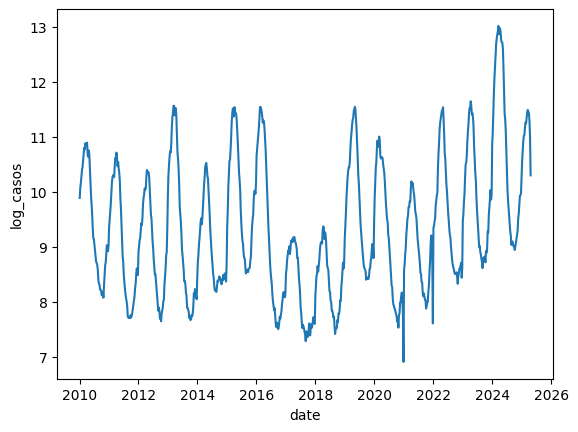

In [14]:
sns.lineplot(data=gdf,x='date',y='log_casos')

## STL
STL is a versatile and robust method for decomposing time series. STL is an acronym for “Seasonal and Trend decomposition using Loess”, while loess is a method for estimating nonlinear relationships. 
STL is a versatile and robust method for decomposing time series. STL is an acronym for “Seasonal and Trend decomposition using Loess”, while loess is a method for estimating nonlinear relationships. 

In [ ]:
STL(